In [2]:
# 读取2017年起的历史指数成分股
import pandas as pd
constituents = pd.read_csv('./computer_index_constituent.csv', index_col = 0)['0']
# 取出所有曾经在这个板块的股票
import ast
all_constituents: list = []
for date in constituents.index:
    all_constituents = set(set(all_constituents).union(set(ast.literal_eval(constituents[date]))))
all_constituents = tuple(all_constituents)
all_constituents[:5]

('300624.SZ', '600410.SH', '600633.SH', '002184.SZ', '300479.SZ')

## 数据

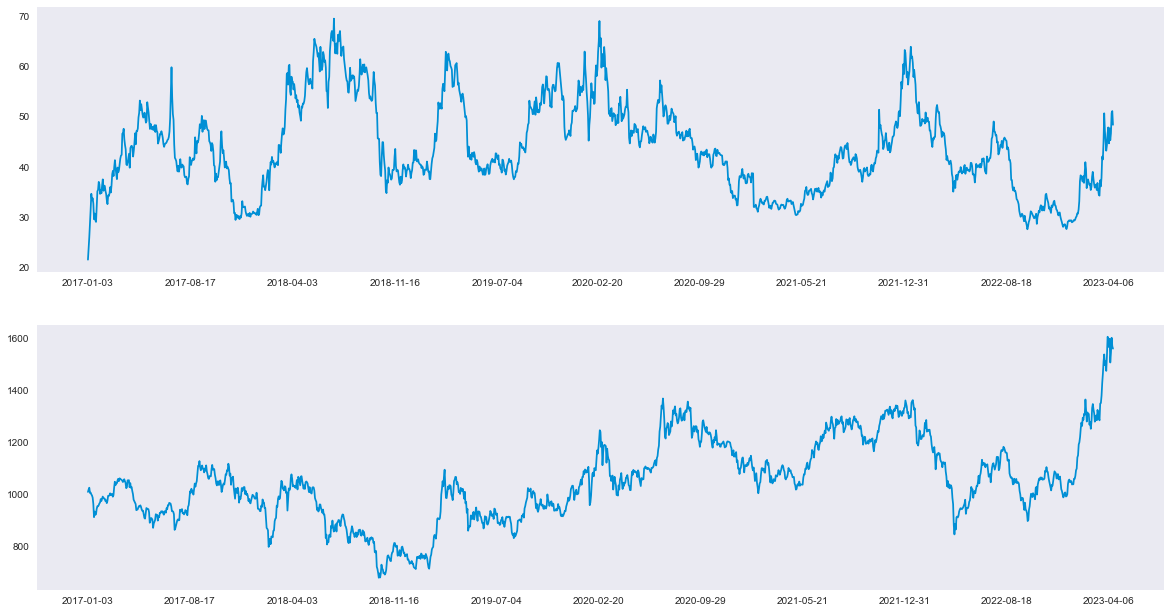

In [11]:
df = pd.read_csv('./stock_data.csv', index_col = 0)
df_bm = pd.read_csv('./benchmark_data.csv', index_col = 0)
import matplotlib.pyplot as plt
import numpy as np
fig, axs = plt.subplots(2, 1, figsize = (18, 10))
my_x_ticks = np.arange(0, len(df_bm.index), int(len(df_bm.index) / 10))#原始数据有13个点，故此处为设置从0开始，间隔为1
axs[1].plot(df_bm.index, df_bm.close)
axs[1].set_xticks(df_bm.index[my_x_ticks])
axs[0].plot(df_bm.index.intersection(df[df.stock == '300571.SZ'].index), df[df.stock == '300571.SZ'].loc[df[df.stock == '300571.SZ'].index.intersection(df_bm.index)].close)
axs[0].set_xticks(df_bm.index[my_x_ticks])
plt.style.use('seaborn-dark')
plt.show()

## 滚动进行拟合

In [29]:
from sklearn import datasets, linear_model
from sklearn.metrics import r2_score
stock = '300571.SZ'
windowsize = 10
df_stock = df[df.stock == stock]
def func(series):
    benchmark = [[close] for close in df_bm.loc[df_bm.index.intersection(series.index)].close]
    if len(benchmark) == windowsize:
        regr = linear_model.LinearRegression()
        regr.fit(benchmark, series)
        series_pred = regr.predict(benchmark)
        return r2_score(series, series_pred)
    else:
        return -1
factor = df_stock.close.rolling(windowsize).apply(func)
factor = factor[factor >= 0]
factor

date
2017-01-16    0.113590
2017-01-17    0.071617
2017-01-18    0.001561
2017-01-19    0.310442
2017-01-20    0.701023
                ...   
2023-04-10    0.179798
2023-04-11    0.396038
2023-04-12    0.613046
2023-04-13    0.457799
2023-04-14    0.272269
Name: close, Length: 1513, dtype: float64

In [43]:
index = df_bm.index.intersection(df[df.stock == '300571.SZ'].index).intersection(factor.index)
index = index[:200]
index

Index(['2017-01-16', '2017-01-17', '2017-01-18', '2017-01-19', '2017-01-20',
       '2017-01-23', '2017-01-24', '2017-01-25', '2017-01-26', '2017-02-03',
       ...
       '2017-10-30', '2017-10-31', '2017-11-01', '2017-11-02', '2017-11-03',
       '2017-11-06', '2017-11-07', '2017-11-08', '2017-11-09', '2017-11-10'],
      dtype='object', name='date', length=200)

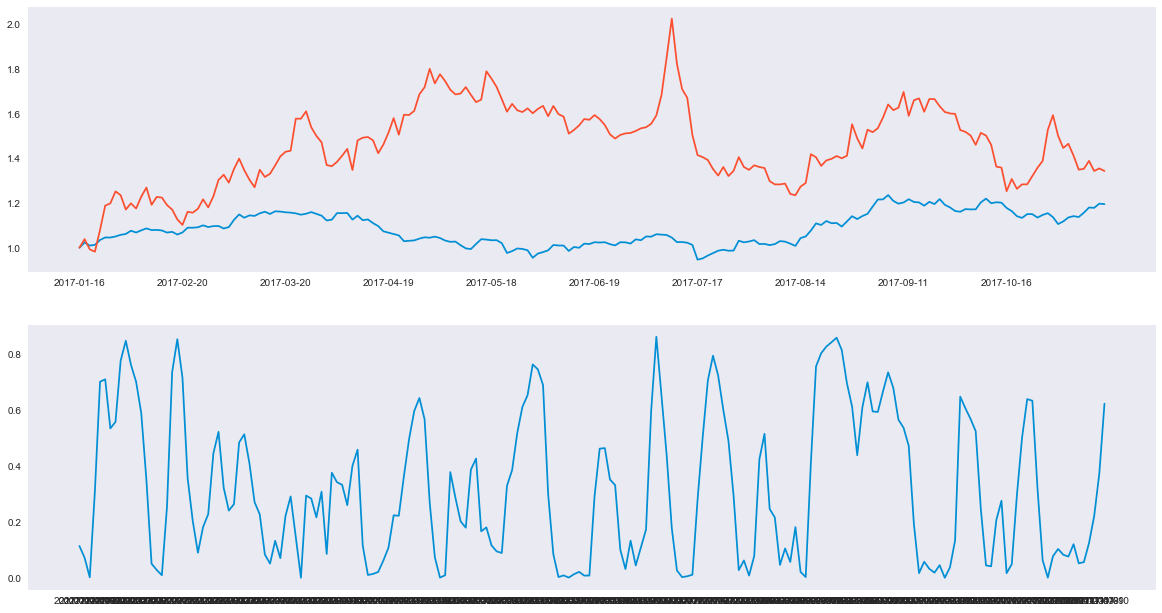

In [44]:
fig, axs = plt.subplots(2, 1, figsize = (18, 10))
my_x_ticks = np.arange(0, len(index), int(len(index) / 10))
axs[0].plot(index, df_bm.loc[index].close / df_bm.loc[index[0]].close)
axs[0].plot(index, df[df.stock == '300571.SZ'].loc[index].close / df[df.stock == '300571.SZ'].loc[index[0]].close)
axs[0].set_xticks(index[my_x_ticks])
axs[1].plot(index, factor[index])
axs[0].set_xticks(index[my_x_ticks])
plt.style.use('seaborn-dark')
plt.show()

获取每个股票的因子值

In [49]:
factor = pd.DataFrame(index = df_bm.index)
for stock in all_constituents:
    windowsize = 10
    df_stock = df[df.stock == stock]
    def func(series):
        benchmark = [[close] for close in df_bm.loc[df_bm.index.intersection(series.index)].close]
        if len(benchmark) == windowsize:
            regr = linear_model.LinearRegression()
            regr.fit(benchmark, series)
            series_pred = regr.predict(benchmark)
            return r2_score(series, series_pred)
        else:
            return -1
    factor_stock = df_stock.close.rolling(windowsize).apply(func)
    factor_stock = factor_stock[factor_stock >= 0]
    factor[stock] = factor_stock

In [77]:
def wsum(cross_section):
    cs = cross_section.transpose()[cross_section.index[0]]
    cs = cs[cs >= 0]
    if len(cs) == 0:
        return -1
    else:
        return cs.sum() / len(cs)
total_factor = factor.groupby('date', group_keys = False).apply(wsum)
total_factor = total_factor[total_factor >= 0]

In [109]:
index = total_factor.index.intersection(df_bm.index)
index = index[1200:]

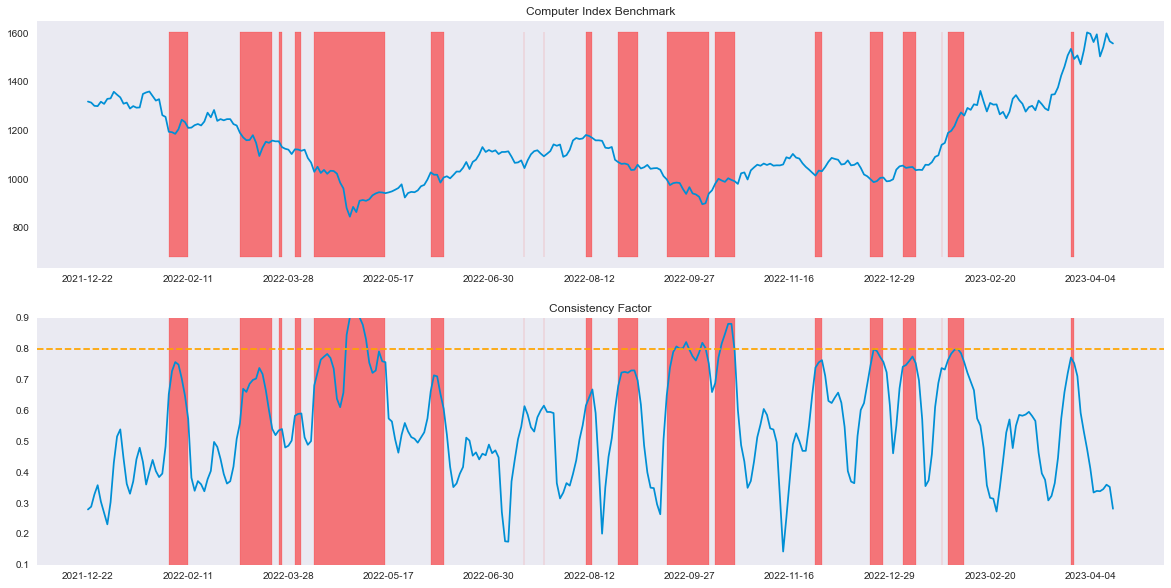

In [110]:
fig, axs = plt.subplots(2, 1, figsize = (18, 10))
my_x_ticks = np.arange(0, len(index), int(len(index) / 10))
greed_zone = total_factor >= total_factor.rolling(252).apply(lambda x: np.percentile(x, 80))
greed_zone = greed_zone[index]
# panic_zone = total_factor <= 0.2
axs[0].plot(index, df_bm.loc[index].close)
axs[0].fill_between(index, df_bm.close.min(), df_bm.close.max(), where=greed_zone, color='red', alpha=0.5)
# axs[0].fill_between(index, df_bm.close.min(), df_bm.close.max(), where=panic_zone, color='green', alpha=0.5)
axs[0].set_xticks(index[my_x_ticks])
axs[0].set_title('Computer Index Benchmark')
axs[1].plot(index, total_factor[index])
axs[1].axhline(y=1, ls='-', c='blue') # 添加水平线
axs[1].axhline(y=0.8, ls='--', c='orange')
axs[1].set_ylim(0.1, 0.9)
axs[1].fill_between(index, 0, 1, where=greed_zone, color='red', alpha=0.5)
# axs[1].fill_between(index, 0, 1, where=panic_zone, color='green', alpha=0.5)
axs[1].set_title('Consistency Factor')
axs[1].set_xticks(index[my_x_ticks])
plt.style.use('seaborn-dark')
plt.show()

In [105]:
total_factor.tail(20)

date
2023-03-17    0.322980
2023-03-20    0.364686
2023-03-21    0.446458
2023-03-22    0.573444
2023-03-23    0.658866
2023-03-24    0.719715
2023-03-27    0.771063
2023-03-28    0.752787
2023-03-29    0.710711
2023-03-30    0.592002
2023-03-31    0.530738
2023-04-03    0.474703
2023-04-04    0.411670
2023-04-06    0.334069
2023-04-07    0.339249
2023-04-10    0.338239
2023-04-11    0.345042
2023-04-12    0.359333
2023-04-13    0.352142
2023-04-14    0.281528
dtype: float64